Specifically, in this post, I'll talk about:

- Matrix Factorisation in Keras
- Adding non-negativitiy constraints to solve non-negative matrix factorisation (NNMF)
- Using neural networks for recommendations
- No scaler
- seed=2020
- create train test val (70/20/10%)

# Select dataset to process

In [1]:
#@title
from sklearn.datasets import dump_svmlight_file
import numpy as np
import pandas as pd
import os
import urllib
import zipfile
from sklearn.model_selection import train_test_split
import shutil

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline

In [2]:
import easydict
args = easydict.EasyDict({
        "hidden_factors": [8,16,32,64],
        'batch':[128,256,512,1024],
        'regularizer': [1e-4,1e-6,1e-8],
        'lr':[0.0001 ,0.0005, 0.001, 0.005],
    })     

In [3]:
#dt_dir_name= "C:/Users/MoNguyen/Desktop/Mo/sample_data/ml-1m/"
dt_dir_name= "C:/Users/thinguyen/Desktop/PhD_2020/Python Code/GNN/Mo/sample_data/ml-100k"


In [4]:
#dataset = pd.read_csv(dt_dir_name+"/u.data",sep='\t',names="user_id,item_id,rating,timestamp".split(","))
#dataset = pd.read_csv(dt_dir_name +'/'+ 'ratings.dat', delimiter='\:\:', names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset = pd.read_csv(dt_dir_name +'/'+ 'implicit_rating.csv', usecols=[0,1,2,3],names=['user_id', 'item_id', 'rating', 'timestamp'])




In [5]:
len(dataset.user_id.unique()), len(dataset.item_id.unique())

(943, 1682)

We assign a unique number between (0, #users) to each user and do the same for movies.


In [6]:
dataset.user_id = dataset.user_id.astype('category').cat.codes.values
dataset.item_id = dataset.item_id.astype('category').cat.codes.values

In [7]:
dataset.head()

,user_id,item_id,rating,timestamp
0,195,241,1,881250949
1,185,301,1,891717742
2,21,376,1,878887116
3,243,50,1,880606923
4,165,345,1,886397596


##Create train, test, val set

In [8]:
#Version 1.2 (flexible + superfast negative sampling uniform)
import random
import time
import scipy

def neg_sampling(ratings_df, n_neg=1, neg_val=0, pos_val=1, percent_print=5):
  """version 1.2: 1 positive 1 neg (2 times bigger than the original dataset by default)

    Parameters:
    input rating data as pandas dataframe: userId|movieId|rating
    n_neg: include n_negative / 1 positive

    Returns:
    negative sampled set as pandas dataframe
            userId|movieId|interact (implicit)
  """
  sparse_mat = scipy.sparse.coo_matrix((ratings_df.rating, (ratings_df.user_id, ratings_df.item_id)))
  dense_mat = np.asarray(sparse_mat.todense())
  print(dense_mat.shape)

  nsamples = ratings_df[['user_id', 'item_id']]
  nsamples['rating'] = nsamples.apply(lambda row: 1, axis=1)
  length = dense_mat.shape[0]
  printpc = int(length * percent_print/100)

  nTempData = []
  i = 0
  start_time = time.time()
  stop_time = time.time()

  extra_samples = 0
  for row in dense_mat:
    if(i%printpc==0):
      stop_time = time.time()
      print("processed ... {0:0.2f}% ...{1:0.2f}secs".format(float(i)*100 / length, stop_time - start_time))
      start_time = stop_time

    n_non_0 = len(np.nonzero(row)[0])
    zero_indices = np.where(row==0)[0]
    if(n_non_0 * n_neg + extra_samples > len(zero_indices)):
      print(i, "non 0:", n_non_0,": len ",len(zero_indices))
      neg_indices = zero_indices.tolist()
      extra_samples = n_non_0 * n_neg + extra_samples - len(zero_indices)
    else:
      neg_indices = random.sample(zero_indices.tolist(), n_non_0 * n_neg + extra_samples)
      extra_samples = 0

    nTempData.extend([(uu, ii, rr) for (uu, ii, rr) in zip(np.repeat(i, len(neg_indices))
                    , neg_indices, np.repeat(neg_val, len(neg_indices)))])
    i+=1

  nsamples=nsamples.append(pd.DataFrame(nTempData, columns=["user_id","item_id", "rating"]),ignore_index=True)
  nsamples.reset_index(drop=True)
  return nsamples

In [9]:
neg_dataset = neg_sampling(dataset)


train, test = train_test_split(neg_dataset, test_size=0.2, random_state=2020)
train, val = train_test_split(train, test_size=0.2, random_state=2020)

# train.reset_index(inplace=True, drop=True)
# test.reset_index(inplace=True, drop=True)
# val.reset_index(inplace=True, drop=True)

(943, 1682)
processed ... 0.00% ...0.00secs
processed ... 4.98% ...0.02secs
processed ... 9.97% ...0.02secs
processed ... 14.95% ...0.01secs
processed ... 19.94% ...0.00secs
processed ... 24.92% ...0.02secs
processed ... 29.90% ...0.00secs
processed ... 34.89% ...0.02secs
processed ... 39.87% ...0.02secs
processed ... 44.86% ...0.02secs
processed ... 49.84% ...0.02secs
processed ... 54.83% ...0.00secs
processed ... 59.81% ...0.02secs
processed ... 64.79% ...0.00secs
processed ... 69.78% ...0.02secs
processed ... 74.76% ...0.00secs
processed ... 79.75% ...0.02secs
processed ... 84.73% ...0.00secs
processed ... 89.71% ...0.02secs
processed ... 94.70% ...0.00secs
processed ... 99.68% ...0.02secs


In [10]:
print(neg_dataset.shape, train.shape, test.shape, val.shape)

(200000, 3) (128000, 3) (40000, 3) (32000, 3)


In [11]:
print(train.shape,"\n", train.head())

(128000, 3) 
         user_id  item_id  rating
100813        6     1210       0
21704       396      173       1
147013      416      884       0
138923      353     1386       0
87201       415      726       1


#Build model using Keras

One popular recommender systems approach is called Matrix Factorisation. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: $A≈W.HT$

In [12]:
#tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.initializers import RandomUniform, he_normal,he_uniform
import math


##Base settings

In [34]:
model_name='model1'
seed=2020
embedding_init = RandomUniform(seed=seed)
relu_init = he_uniform(seed=seed)
#regu =l2(1e-6)

##Create MF model 

In [52]:
def create_model(dataset, n_latent_factors = 16, learning_rate=0.1,regu=1e-6):
  n_users, n_movies = len(dataset.user_id.unique()), len(dataset.item_id.unique())
  #n_latent_factors = 16

  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding = keras.layers.Embedding(n_movies, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=l2(regu), 
                                          embeddings_constraint="NonNeg", 
                                          name='Movie-Embedding')(movie_input)
  movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

  user_input = keras.layers.Input(shape=[1],name='User')
  user_embedding = keras.layers.Embedding(n_users, n_latent_factors, 
                                          embeddings_initializer=embedding_init, 
                                          embeddings_regularizer=l2(regu), 
                                          embeddings_constraint="NonNeg", 
                                          name='User-Embedding')(user_input)
  user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

  prod = keras.layers.dot([movie_vec, user_vec], axes=1,normalize=True,name='DotProduct')
  model = keras.Model([user_input, movie_input], prod)
  sgd= tf.keras.optimizers.SGD(learning_rate)
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['binary_accuracy'])
  return model

In [53]:
model = create_model(neg_dataset,args.hidden_factors[0],args.lr[0],args.regularizer[0]) 

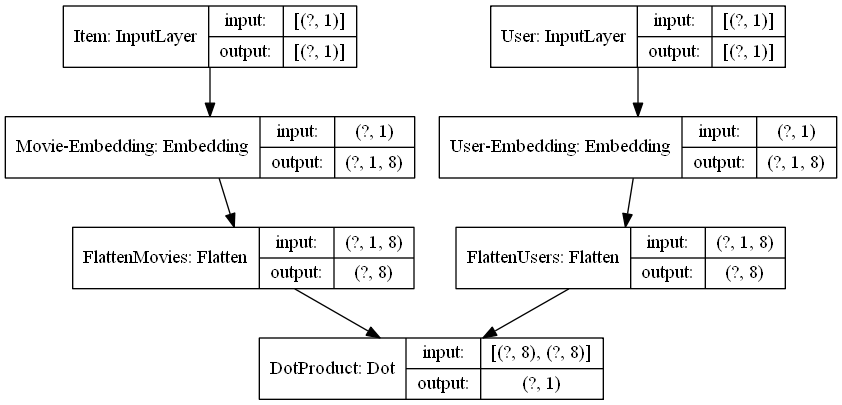

In [45]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [46]:
dataset.index

RangeIndex(start=0, stop=100000, step=1)

##Create data generator class

The class generate the sample for training dynamically

In [54]:
from tensorflow.keras.utils import Sequence
import math

class DataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=16, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.shuffle = shuffle
        self.indices = dataframe.index
        print(len(self.indices))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return math.floor(len(self.dataframe) / self.batch_size)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = [i for i in range(index*self.batch_size,(index+1)*self.batch_size)]
        
        # Find list of batch IDs
        list_IDs_temp = [self.indices[k] for k in idxs]

        # Generate data
        User = self.dataframe.loc[list_IDs_temp,['user_id']].to_numpy()#.reshape(-1)
        Item = self.dataframe.loc[list_IDs_temp,['item_id']].to_numpy()#.reshape(-1)
        rating = self.dataframe.loc[list_IDs_temp,['rating']].to_numpy()#.reshape(-1)
        #print("u,i,r:", [User, Item],[y])
        return [User, Item],[rating]

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indices)


##Trainging the model (2 options)

 - Normal fit
 - Fit generator

In [57]:

for i in args.lr:
    for j in args.batch:
        for k in args.hidden_factors:
            for l in args.regularizer:
                model=create_model(neg_dataset,k,i,l)
                history = model.fit([train.user_id, train.item_id], train.rating, batch_size=j, epochs=100,  verbose=0 )
                results = model.evaluate((test.user_id, test.item_id), test.rating, batch_size=1,verbose=0)
      
                print('RESULT: lr=',i, 'regularization=',l, ' batch=', j, 'hidden factors=', k, results)

RESULT: lr= 0.0001 regularization= 0.0001  batch= 128 hidden factors= 8 [0.5940358085018582, 0.78935]
RESULT: lr= 0.0001 regularization= 1e-06  batch= 128 hidden factors= 8 [0.5566599222515477, 0.783625]
RESULT: lr= 0.0001 regularization= 1e-08  batch= 128 hidden factors= 8 [0.5488861268492844, 0.77905]
RESULT: lr= 0.0001 regularization= 0.0001  batch= 128 hidden factors= 16 [0.7012362745895981, 0.8212]
RESULT: lr= 0.0001 regularization= 1e-06  batch= 128 hidden factors= 16 [0.4389003849832341, 0.8211]
RESULT: lr= 0.0001 regularization= 1e-08  batch= 128 hidden factors= 16 [0.4264857286374521, 0.81745]
RESULT: lr= 0.0001 regularization= 0.0001  batch= 128 hidden factors= 32 [0.4157380153934762, 0.826225]
RESULT: lr= 0.0001 regularization= 1e-06  batch= 128 hidden factors= 32 [0.4113773840139369, 0.826175]
RESULT: lr= 0.0001 regularization= 1e-08  batch= 128 hidden factors= 32 [0.41112864056314513, 0.826275]
RESULT: lr= 0.0001 regularization= 0.0001  batch= 128 hidden factors= 64 [0.417

RESULT: lr= 0.0005 regularization= 1e-08  batch= 512 hidden factors= 32 [0.43513936900998995, 0.812225]
RESULT: lr= 0.0005 regularization= 0.0001  batch= 512 hidden factors= 64 [0.4762408070119098, 0.795725]
RESULT: lr= 0.0005 regularization= 1e-06  batch= 512 hidden factors= 64 [0.4742024579568999, 0.792875]
RESULT: lr= 0.0005 regularization= 1e-08  batch= 512 hidden factors= 64 [0.4741175822557736, 0.7931]
RESULT: lr= 0.0005 regularization= 0.0001  batch= 1024 hidden factors= 8 [0.7239589029010385, 0.77715]
RESULT: lr= 0.0005 regularization= 1e-06  batch= 1024 hidden factors= 8 [0.7112083863809705, 0.771175]
RESULT: lr= 0.0005 regularization= 1e-08  batch= 1024 hidden factors= 8 [0.5599329201498803, 0.7732]
RESULT: lr= 0.0005 regularization= 0.0001  batch= 1024 hidden factors= 16 [0.44920519690711225, 0.80345]
RESULT: lr= 0.0005 regularization= 1e-06  batch= 1024 hidden factors= 16 [0.44826920565959355, 0.8032]
RESULT: lr= 0.0005 regularization= 1e-08  batch= 1024 hidden factors= 16 

RESULT: lr= 0.005 regularization= 1e-08  batch= 256 hidden factors= 16 [0.4222670183958826, 0.8201]
RESULT: lr= 0.005 regularization= 0.0001  batch= 256 hidden factors= 32 [0.41789079982425903, 0.82275]
RESULT: lr= 0.005 regularization= 1e-06  batch= 256 hidden factors= 32 [0.4166341421470643, 0.822375]
RESULT: lr= 0.005 regularization= 1e-08  batch= 256 hidden factors= 32 [0.41577595435585873, 0.822525]
RESULT: lr= 0.005 regularization= 0.0001  batch= 256 hidden factors= 64 [0.4340823135837214, 0.81585]
RESULT: lr= 0.005 regularization= 1e-06  batch= 256 hidden factors= 64 [0.43191401463543405, 0.814775]
RESULT: lr= 0.005 regularization= 1e-08  batch= 256 hidden factors= 64 [0.431998569162296, 0.8148]
RESULT: lr= 0.005 regularization= 0.0001  batch= 512 hidden factors= 8 [0.671676203070581, 0.771975]
RESULT: lr= 0.005 regularization= 1e-06  batch= 512 hidden factors= 8 [0.5665159305208363, 0.77765]
RESULT: lr= 0.005 regularization= 1e-08  batch= 512 hidden factors= 8 [0.53993459190978

In [ ]:
#1 Normal training with fit method (uncomment to run)

history = model.fit([train.user_id, train.item_id], train.rating, batch_size=256, epochs=100,  verbose=2 )

In [49]:
#2  training with fit generator
#train_generator = DataGenerator(dataframe=train, batch_size=256, shuffle=False)
#val_generator = DataGenerator(dataframe=val, batch_size=256, shuffle=False)
#history = model.fit(train_generator, epochs=100, verbose=2)

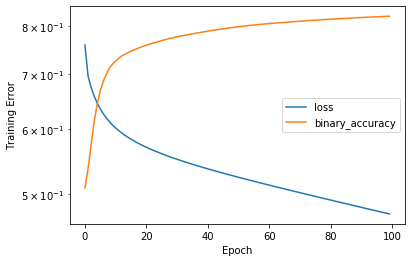

In [58]:
pd.Series(history.history['loss']).plot(logy=True)
pd.Series(history.history['binary_accuracy']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Training Error")
plt.legend(['loss','binary_accuracy'])

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [ ]:
results = model.evaluate((test.user_id, test.item_id), test.rating,
                            batch_size=16)

In [ ]:
print(results)

In [ ]:
#y_hat = np.round(model.predict([test.user_id, test.item_id]),0)
y_hat = model.predict([test.user_id, test.item_id])
y_true = test.rating
print('y_hat:', y_hat)
print('y_true',y_true)

In [ ]:
y_true=y_true.to_numpy()
y_true.shape= (1,400084)

In [ ]:
y_score=y_hat
y_score


In [ ]:
#y_temp=y_score.round()
y_temp=y_score
y_temp=y_temp.transpose()
#y_true.shape=(1,400084)

In [ ]:
print(type(y_temp))
print(y_temp)
print(y_temp.shape)

print(type(y_true))
print(y_true)
print(y_true.shape)

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_true, y_temp)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_tr, y_pr)

In [ ]:
#NDCG calculation
from sklearn.metrics import ndcg_score
#ndcg_score(y_true, y_hat,k=1,ignore_ties=True)
ndcg_score(y_true, y_temp)

In [ ]:
import numpy as np
from sklearn.metrics import label_ranking_average_precision_score
label_ranking_average_precision_score(y_true, y_temp)

In [ ]:
for i in y_true:    
    y_tr=i.tolist()
#print(y_tr)
print(type(y_tr))

In [ ]:
for i in y_temp:
    tmp=i.tolist()
#print(y_tr)
print(type(y_pr))

In [ ]:

y_pr=[]
for i in tmp:
    y_pr.append(int(i))
print(y_pr)

In [ ]:
from sklearn.metrics import recall_score
#y_tr = [0, 1, 2, 0, 1, 2]
#y_pr = [0, 2, 1, 0, 0, 1]
recall_score(y_tr, y_pr, average='weighted')



In [ ]:
#RESULTS
print('Model 1 TEST result')
print('Accuracy:',accuracy_score(y_tr, y_pr))
print('Precision:',label_ranking_average_precision_score(y_true, y_temp))
print('Recall:',recall_score(y_tr, y_pr, average='weighted'))
print('NDCG:',ndcg_score(y_true, y_temp))




#Extracting the learnt embeddings
We can extract the learnt movie and item embeddings as follows:

In [ ]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

In [ ]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

In [ ]:
user_embedding_learnt

In [ ]:
user_embedding_learnt.shape

In [ ]:
#SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

#Recommend top n movies

In [ ]:
def recommend(user_id, number_of_movies=5):
  movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
  mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
  return mids

In [ ]:
recommend(user_id=1)

#Experimental results:
A. NO scale
1. array([ 482,   56, 1462, 1397, 1642]) --> normal training (fit) 100 epoches
2. array([1638,  118, 1466, 1448, 1627]) --> generator training (fit_generator) 20 epoches
3. array([ 901,  319, 1404, 1448, 1642])--> generator training (fit_generator) 50 epoches
4. array([1642,  614,  588, 1193,  640]) --> GT 100 ep

#References
https://nipunbatra.github.io/blog/2017/recommend-keras.html

https://medium.com/sfu-big-data/recommendation-systems-collaborative-filtering-using-matrix-factorization-simplified-2118f4ef2cd3

[Keras regularizer](https://keras.io/regularizers/)